# Hyperparameter Tuning

In machine learning, hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a parameter whose value is used to control the learning process. By contrast, the values of other parameters (typically node weights) are learned.

In [1]:
import json
import pandas as pd
import numpy as np
import pickle
from pprint import pprint
from sklearn import svm
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

/Users/dazconap/Projects/edm-modeling/env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 25 }
plt.rc('font', **font)

In [3]:
np.random.seed(42)

In [4]:
# %pprint # ON and OFF

In [5]:
PASS_THRESHOLD = 40

In [6]:
weeks = range(1, 13)

In [7]:
_course = 'ca116'

In [8]:
training_and_validation_years = [
    (2016, 2017),
    (2017, 2018)
]

In [9]:
exams = [4, 8, 12]

Dictionary of given a week, which exam should we predicting next?

In [10]:
def get_week_to_exam(exam_weeks):
    week_to_exam = {}
    curr = exam_weeks[-1]
    for i in reversed(range(12)):
        week = i + 1
        if week in exam_weeks:
            curr = week
        week_to_exam[week] = curr
    return week_to_exam

In [11]:
week_to_exam = get_week_to_exam(exams)

In [12]:
week_to_exam

{12: 12, 11: 12, 10: 12, 9: 12, 8: 8, 7: 8, 6: 8, 5: 8, 4: 4, 3: 4, 2: 4, 1: 4}

In [13]:
def get_scorings():
    return [
        "roc_auc",
        "f1",
        "precision",
        "recall",
        "accuracy",
        "average_precision",
    ]

In [14]:
def calculate_cross_val_score(algorithm, X, Y, nfolds, scoring="roc_auc"):
    cv = StratifiedKFold(Y, n_folds=nfolds)
    scores = cross_val_score(algorithm, X, Y, scoring=scoring, cv=cv)
    return scores.mean(), scores.std()

In [15]:
THRESHOLD = 40

In [16]:
# FEATURES

data = []

for _year in training_and_validation_years:

    print('## YEAR: {} ##'.format(_year))
    
    filename = '../../data/features/features_%s_%s.json' % (_course.upper(), _year[1])
    with open(filename) as f:
        data.extend(json.load(f))

## YEAR: (2016, 2017) ##
## YEAR: (2017, 2018) ##


In [17]:
def get_grid_search():

    pipe = Pipeline([("classifier", RandomForestClassifier())])

    search_space = [
        {"classifier": [ RandomForestClassifier() ],
         "classifier__n_estimators": [10, 100, 1000],
         "classifier__max_features": [1, 2, 3]}
    ]
    
    # {"classifier": [ RandomForestClassifier() ],
    # "classifier__n_estimators": [10, 100, 1000],
    # "classifier__max_features": [1, 2, 3]}
    
    # {"classifier": [ KNeighborsClassifier() ],
    # "classifier__n_neighbors": np.arange(3, 15, 3)}
    
    # {"classifier": [ LogisticRegression() ],
    # "classifier__penalty": ['l1', 'l2'],
    # "classifier__C": np.logspace(0, 4, 5)}
    
    # {"classifier": [ svm.SVC() ],
    # "classifier__C": np.logspace(0, 4, 5),
    #"classifier__kernel": ['linear', 'poly', 'rbf']}
    
    return GridSearchCV(pipe, search_space, cv=5, verbose=0)

In [18]:
import warnings
warnings.filterwarnings('ignore') # "error", "ignore", "always", "default", "module" or "once"

In [19]:
# Students to TRAIN and VALIDATE for each exam

X_train_students, X_val_students = {}, {}

for exam in exams:
    
    # Students to train and their results
    X_train_students[exam] = np.load('../../data/features/X_train_{}.npy'.format(exam))

    # Students to validate and their results
    X_val_students[exam] = np.load('../../data/features/X_val_{}.npy'.format(exam))

# TRAIN
    
cols_to_remove = ['academic_year_0', 'academic_year_1', 'course', 'route', # For now route is removed
                  'student', 'week', 'exam', 'grade', 'domicile']

labels = [0, 1]

means = []

for week in range(1, 13):

    # Target exam
    exam = week_to_exam[week]

    print('* Week: {}, Exam: {} *'.format(week, exam))

    # data
    week_data = pd.DataFrame([ d for d in data if d['week'] == week ])

    # training data
    training_data = week_data[ week_data['student'].isin(X_train_students[exam]) ]

    X_train = training_data.drop(cols_to_remove, axis=1)
    y_train = training_data['grade'] >= THRESHOLD

    # validation data
    validation_data = week_data[ week_data['student'].isin(X_val_students[exam]) ]

    X_val = validation_data.drop(cols_to_remove, axis=1)
    y_val = validation_data['grade'] >= THRESHOLD
        
    pct_passsing = sum(y_train) / float(len(y_train))
    
    print('Rows: Train {}, Validate {}, Passing rate: {:.2f}'.format(len(X_train), len(X_val), pct_passsing))
    
    # fill NA
    X_train.fillna(0, inplace=True)
    X_val.fillna(0, inplace=True)
    
    # Grid Search
    gridsearch = get_grid_search()

    # Fit
    best_model = gridsearch.fit(X_train, y_train)
        
    print(best_model.best_estimator_.get_params()['classifier'])
        
    filename = '../../data/models/model_week_%s.pkl' % (week)
    joblib.dump(best_model, filename)
        
    print('Calculating scores:')
    scores = cross_val_score(gridsearch, X_val, y_val, scoring='f1')

    print(scores)

    print('Scores Mean: %f' % (scores.mean()))
    
    means.append(scores.mean())

* Week: 1, Exam: 4 *
Rows: Train 225, Validate 59, Passing rate: 0.83
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=1, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Calculating scores:
[0.83333333 0.91428571 0.88235294]
Scores Mean: 0.876657
* Week: 2, Exam: 4 *
Rows: Train 225, Validate 59, Passing rate: 0.83
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
      

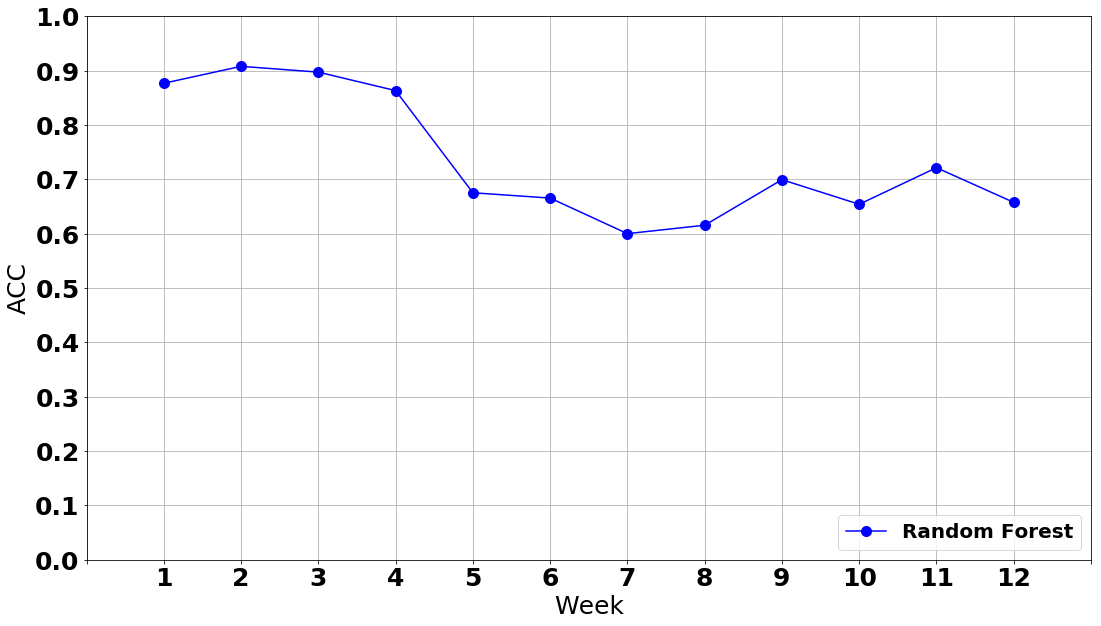

In [22]:
fig, ax = plt.subplots(figsize=(18, 10))
plt.ylim(*(0, 1))
plt.rc('font', **font)
plt.xlabel("Week")
plt.ylabel('ACC')
weeks = range(1, 13)
plt.grid()
plt.plot(weeks, means, 'o-', color='blue', label='Random Forest', markersize=10)
plt.xticks(np.arange(0, len(weeks) + 2))
plt.yticks(np.arange(0, 1.1, 0.1))
# Hide labels
plt.setp(ax.get_xticklabels()[0], visible=False)
plt.setp(ax.get_xticklabels()[-1], visible=False)
plt.legend(loc="lower right", fontsize=20)
filename = '../../figures/{}_Hyperparameter_Tuning_Random_Forest.png'.format(_course.upper())
plt.savefig(filename, format='png', bbox_inches="tight", dpi=100)